In [1]:
import os 
os.chdir("../src")
print(os.getcwd())
import copy

import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.utils import io

from envs.goal_demo_wrapper import GoalDemoWrapper
from utils.load_confs import load_parameters, load_paths

%matplotlib inline
%load_ext autoreload
%autoreload 2

/u/clw4542/research/rl_ifo_mujoco/src


In [5]:
ENV_IDS = [
           "Reacher-v2",
           "Swimmer-v2", 
           "Ant-v2", 
           "Hopper-v2", 
           "Walker2d-v2", 
           "HalfCheetah-v2"
          ]

paths = load_paths()
params = load_parameters()

RESULTS_DIR = paths['rl_demo']['results_dir']
expt_name = "her_demo"
algo = "sac"

# control variables
raw, obs_type = True, "raw"
time_feat = True
displace_t = 1
demo_dict = params["her_demo"]["demo_algo"]

### Plotting Utils

In [6]:
random_perf = {
               'Reacher-v2': {"ret": -43.1199222,
                              'optimal_goal-dist': 102.94778817288184,
                              'medium_goal-dist': 114.21570126810595,
                              'worst_goal-dist': 142.1727936522922,
                              'random_goal-dist': 139.0812864536828
                             }, 

               'HalfCheetah-v2': {"ret": -282.7423069,
                                  'optimal_goal-dist': 1316.2468678170692,
                                  'medium_goal-dist': 1321.765717231416,
                                  'worst_goal-dist': 1225.9308478261776,
                                  'random_goal-dist': 958.7524994584503
                                 }, 
               'Ant-v2': {"ret": -54.35667815,
                          'optimal_goal-dist': 1482.1148244903445,
                          'medium_goal-dist': 1512.326710452443,
                          'worst_goal-dist': 1436.6197684456367,
                          'random_goal-dist': 1378.0341266287257
                         }, 
               'Walker2d-v2': {"ret": 0.55296615,
                               'optimal_goal-dist': 35.409822850297,
                               'medium_goal-dist': 26.131589529193658,
                               'worst_goal-dist': 27.378735829954508,
                               'random_goal-dist': 26.367460484293424
                              }, 
               'Swimmer-v2': {"ret": 1.4335161,
                              'optimal_goal-dist': 2250.6821455130303,
                              'medium_goal-dist': 2366.3265878390534,
                              'worst_goal-dist': 2499.692321340913,
                              'random_goal-dist': 2076.9467436289383
                             }, 
               'Hopper-v2': {"ret":18.14677599,
                             'optimal_goal-dist': 2002.7879088181642,
                             'medium_goal-dist': 2166.11858980727,
                             'worst_goal-dist': 2126.7812898846073,
                             'random_goal-dist': 1458.8889784643468
                            }
}

expert_perf = {}
expert_average_perf = {}

for env_id in ENV_IDS:
    expert_perf[env_id] = {}
    expert_average_perf[env_id] = {}
    for demo_level, demo_algo in demo_dict[env_id.replace("-v2", "").lower()].items():    
        data = np.load(f"../data/expert_joint_angle_traj/original_init/joint_angles_{demo_algo}.{env_id}.seed=None.npz")
        rew = data['rew']
        expert_perf[env_id][demo_level] = rew

        data = np.load(f"../data/expert_full_traj/original_init/{demo_algo}.{env_id}.seed=None.npz")
        expert_average_perf[env_id][demo_level] = np.mean(data['ep_rets'])

In [8]:
expert_perf

{'Reacher-v2': {'optimal': array(-2.43314369),
  'medium': array(-5.48492829),
  'worst': array(-17.67537716),
  'random': array(-44.24799087)},
 'Swimmer-v2': {'optimal': array(51.22937576),
  'medium': array(34.47597531),
  'worst': array(25.14392567),
  'random': array(-1.8470352)},
 'Ant-v2': {'optimal': array(6320.13610766),
  'medium': array(4945.65820247),
  'worst': array(2694.8177868),
  'random': array(-294.68416934)},
 'Hopper-v2': {'optimal': array(3919.14106004),
  'medium': array(3410.76776157),
  'worst': array(2903.92125184),
  'random': array(914.70556166)},
 'Walker2d-v2': {'optimal': array(4635.69685525),
  'medium': array(3753.85048328),
  'worst': array(2290.94450704),
  'random': array(947.68037382)},
 'HalfCheetah-v2': {'optimal': array(12352.00003832),
  'medium': array(10304.16457158),
  'worst': array(8509.23424322),
  'random': array(-208.24717481)}}

In [5]:
# get all demos + ts
expert_perf = {}
expert_average_perf = {}

for env_id in ENV_IDS:
    expert_perf[env_id] = {}
    expert_average_perf[env_id] = {}        

    max_train_ts = int(params["sac"][env_id.replace("-v2", "").lower()]["max_timesteps"])
    ts_list = [f"ts={i}" for i in range(max_train_ts // 5 - 1000, max_train_ts, max_train_ts // 5)] 
        #     Walker2d-v2 only 
#     manual_ts = [579923, 1184189, 1795235, 2394330, 2994242]
#     ts_list = [f"ts={i}" for i in manual_ts]
    for demo_algo in [*ts_list, "best", "long"]:
        demo_algo = f"sac-{demo_algo}"   
        data = np.load(f"../data/expert_joint_angle_traj/original_init/joint_angles_{demo_algo}.{env_id}.seed=None.npz")
        rew = data['rew']
        expert_perf[env_id][demo_algo] = rew

    data = np.load(f"../data/expert_full_traj/original_init/{demo_algo}.{env_id}.seed=None.npz")
    expert_average_perf[env_id][demo_level] = np.mean(data['ep_rets'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/expert_joint_angle_traj/original_init/joint_angles_sac-ts=39000.Reacher-v2.seed=None.npz'

In [13]:
from collections import deque 
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import tensorflow as tf
import copy

%matplotlib inline

def combine_eval_logs(log_base, normalize=True, env_id=None, demo_level=None,
                      run_ids=[1,2,3,4,5], max_ts=3e+6
                     ):
    results_all, ep_lens_all, goal_dists_all = [], [], []
    for run_id in run_ids:
        log_path = f"{log_base}_{run_id}/"
        # TODO: even if path doesn't exist, just print warning
        ts, results, ep_lens, goal_dists = read_eval_data(log_path, max_ts=max_ts, 
                                                          normalize=normalize, 
                                                          env_id=env_id, demo_level=demo_level)
        results_all.append(results)  # shape (ts, n_evals, 1 )
        ep_lens_all.append(ep_lens)
        goal_dists_all.append(goal_dists)
        
    combi_mean = lambda x: (np.concatenate(x, axis=1)
                              .squeeze()
                              .mean(axis=1))
    combi_std = lambda x: (np.concatenate(x, axis=1)
                              .squeeze()
                              .std(axis=1))
    
    mean_results, std_results = combi_mean(results_all), combi_std(results_all)
    mean_ep_lens, std_ep_lens = combi_mean(ep_lens_all), combi_std(ep_lens_all)
    if np.count_nonzero(goal_dists_all) == 0:
        mean_goal_dists, std_goal_dists = [], []
    else:
        mean_goal_dists, std_goal_dists = combi_mean(goal_dists_all), combi_std(goal_dists_all)

    return (ts, mean_results, std_results,
            mean_ep_lens, std_ep_lens,
            mean_goal_dists, std_goal_dists)
                

def normalizer(x:np.ndarray, max_value:float, min_value:float):
    return (x - min_value) / (max_value - min_value)


def read_eval_data(log_path:str,
                   normalize=True,
                   env_id=None,
                   demo_level=None,
                   max_ts=3e+6
                  ):
    eval_data = np.load(os.path.join(log_path, "evaluations.npz"))
    ts = eval_data["timesteps"]
    results = eval_data["results"]
    ep_lens = eval_data["ep_lengths"]
        
    truncated_ts = [i for i in ts if i < max_ts]
    max_idx = len(truncated_ts)
    
    goal_dist = np.array([])
    if "goal_dists" in eval_data.keys():
        goal_dist = eval_data["goal_dists"]

    if normalize:
        results = normalizer(results, 
                             max_value=expert_perf[env_id]["optimal"], 
                             min_value=random_perf[env_id]["ret"]
                           )
        goal_dist = normalizer(goal_dist,
                              max_value=random_perf[env_id][f"{demo_level}_goal-dist"],
                              min_value=0)
        
    return ts[:max_idx], results[:max_idx], \
           ep_lens[:max_idx], goal_dist[:max_idx]
    
        
def plot_algo_with_demo(logs_dict, 
                        axis,
                        env_id,
                        normalize=True,
                        demo_level=None, 
                        algo=None,
                        eval_mode=False,
                        show_demo_labels=True
                       ):
    '''the result should be a tuple of 2 lists, representing the x and y coords to plot'''
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result            
        color = algo_colors[label]
        p = axis.plot(time_idx, mean, label=label, color=color)
        std = np.array(std)
        axis.fill_between(time_idx, mean-std, mean+std,
                        alpha=0.5, edgecolor=color, facecolor=color 
                       )
    
    demo_perf_copy = copy.deepcopy(expert_perf[env_id])
    demo_perf_copy["random"] = random_perf[env_id]['ret']
    if normalize:
        normalize_return = lambda x: normalizer(x, max_value=expert_perf[env_id]["optimal"], min_value=random_perf[env_id]["ret"])
        demo_perf_copy["optimal"] = normalize_return(demo_perf_copy["optimal"])
        demo_perf_copy["medium"] = normalize_return(demo_perf_copy["medium"])
        demo_perf_copy["worst"] = normalize_return(demo_perf_copy["worst"])
        demo_perf_copy["random"] = normalize_return(demo_perf_copy["random"])

    if demo_level in ["worst", "medium", "optimal"]:
        label = f"{demo_level} demo" if demo_level != "optimal" else "best demo"
        axis.axhline(y=demo_perf_copy[demo_level], color=algo_colors[label], linestyle='--', 
                     label="demo" if show_demo_labels else None)
    elif demo_level == "all":
        axis.axhline(y=demo_perf_copy["optimal"], color=algo_colors['best demo'], linestyle='--', 
                     label='best demo' if show_demo_labels else None)
        axis.axhline(y=demo_perf_copy["medium"], color=algo_colors['medium demo'], linestyle='--', 
                     label='medium demo' if show_demo_labels else None)
        axis.axhline(y=demo_perf_copy["worst"], color=algo_colors['worst demo'], linestyle='--', 
                     label='worst demo' if show_demo_labels else None)
        axis.axhline(y=demo_perf_copy['random'], color=algo_colors['random demo'], linestyle='--', 
                     label='random demo' if show_demo_labels else None)
        
    axis.set_title(f"{env_id.replace('-v2','').lower()}", fontsize=15)
    axis.xaxis.set_major_formatter(ticker.EngFormatter())
    if not normalize:
        axis.yaxis.set_major_formatter(ticker.EngFormatter())

    
def plot_goal_dist(logs_dict, axis, env_id, algo=None):
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result
        if len(mean_goal_dist) == 0:
            continue
        color = algo_colors[label]
        p = axis.plot(time_idx, mean_goal_dist, label=label, color=color)
#         color = p[0].get_color()
        std_goal_dist = np.array(std_goal_dist)
        axis.fill_between(time_idx, 
                          mean_goal_dist-std_goal_dist, 
                          mean_goal_dist+std_goal_dist,
                          alpha=0.5, edgecolor=color, facecolor=color 
                         )
    axis.set_title(f"{env_id.replace('-v2', '').lower()}", fontsize=15)
    axis.xaxis.set_major_formatter(ticker.EngFormatter())

    
def plot_ep_lens(logs_dict, algo, env):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result
        p = ax.plot(time_idx, mean_lens, label=label)
        color = p[0].get_color()
        std_lens = np.array(std_lens)
        ax.fill_between(time_idx, mean_lens-std_lens/2, mean_lens+std_lens/2,
                        alpha=0.5, edgecolor=color, facecolor=color 
                       )

    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Ep Len of {algo.upper()} on {env}", fontsize=20)
    ax.set_xlabel("Timesteps", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.show()
    plt.close()


def newest(path):
    '''Returns full path of newest file in given path'''
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages

### Figures

In [25]:
algo_colors = {
    # core
    "SAC": "midnightblue",
    "RIDM": "C3",
    "D-Shape (ours)": "C1",
    "D-Shape (ours), sign corrected": "C3",
    "D-Shape (ours), goal_strat=random": "C3",

    "D-Shape (pretrain)": "C1",
    "D-Shape (no pretrain)": "C3",

    "D-Shape (ours), RE=0.1": "C0",
    "D-Shape (ours), RE=0.2": "C3",

    "D-Shape": "C1",
    "SBS": "C2",
    # vary demo
    "best demo": "C0", # blue
    "medium demo": "C1", # orange
    "worst demo": "C2", # green
    "random demo": "C3", # red

    "D-Shape, demo=medium, dist neg": "C0",
    "D-Shape, demo=medium, dist pos": "C1",
    "D-Shape, demo=medium, dist neg, sin-cos": "C2",
    "D-Shape, demo=medium, dist pos, sin-cos": "C3",
    
    "D-Shape, demo=optimal, dist neg": "C0",
    "D-Shape, demo=optimal, dist pos": "C1",
    "D-Shape, demo=optimal, dist neg, sin-cos": "C2",
    "D-Shape, demo=optimal, dist pos, sin-cos": "C3",

    "D-Shape, demo=medium, dist neg, gamma=1": "C0",
    "D-Shape, demo=medium, dist pos, gamma=1": "C2",
    "D-Shape, demo=medium, dist pos, gamma=0.99": "green",
    "D-Shape, demo=medium, dist neg, gamma=0.999999": "C3",
    "D-Shape, demo=medium, dist pos, gamma=0.999999": "C1",
    "D-Shape, demo=medium, buffer=small": "C3",

    "D-Shape, demo=medium, dist neg, sparse-rew": "C0",
    "D-Shape, demo=medium, dist pos, sparse-rew": "C1",
    "D-Shape, demo=medium, dist neg, sparse-rew": "C2",
    "D-Shape, demo=medium, dist pos, sparse-rew": "C3",
    
    "D-Shape, demo=optimal, dist neg, sparse-rew": "C0",
    "D-Shape, demo=optimal, dist pos, sparse-rew": "C1",
    "D-Shape, demo=optimal, dist neg, sparse-rew": "C2",
    "D-Shape, demo=optimal, dist pos, sparse-rew": "C3",

    "D-Shape, demo=best": "C0",
    "D-Shape, demo=medium": "C1",
    "D-Shape, demo=worst": "C2",
    "D-Shape, demo=random": "C3",
    "SAC+Huber, demo=best": "C0",
    "SAC+Huber, demo=medium": "C1",
    "SAC+Huber, demo=worst": "C2",
    "SAC+Huber, demo=random": "C3",
    # ablation
    "D-Shape − GR − shaping": "C3",
    "D-Shape − GR − state_aug": "purple",
    "D-Shape − GR": "teal",
    
}

ENV_IDS = [
           "Reacher-v2",
#            "Swimmer-v2", 
#            "Ant-v2", 
#            "Hopper-v2", 
#            "HalfCheetah-v2",
#            "Walker2d-v2"
          ]
fig_locs = {env_id: i for i, env_id in enumerate(ENV_IDS)}

goal_strat = "episode"
termphi0 = True
normalize = True
run_ids = [1,2,3,4,5]


/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


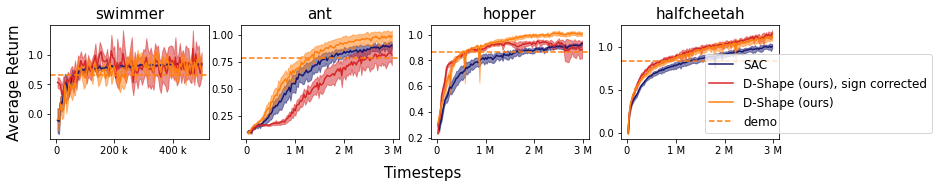

In [40]:
# core result
for demo_level in ["medium"]:
    figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))

    for env_id in ENV_IDS:
        eval_data_dict = {
                  f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, run_ids = run_ids, demo_level=demo_level, normalize=normalize),        
#                   f"RIDM": combine_eval_logs(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level),                                     
#                   f"D-Shape (pretrain)": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}_pretrain=bc/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
#                   f"D-Shape (ours), goal_strat=random": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat=random_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}_pretrain=False/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
                  f"D-Shape (ours), sign corrected": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}_SIGNNEG/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
                  f"D-Shape (ours)": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
        }
        plot_algo_with_demo(eval_data_dict, 
                            axis=axis[fig_locs[env_id]],
                            demo_level=demo_level,
                            env_id=env_id, eval_mode=True,
                            normalize=normalize)
#     figure.suptitle(f"Goal strategy={goal_strat}, demo={demo_level}\n",
#                    fontsize=15)
    figure.text(0.70, -0.1, "Timesteps", 
                ha='center', va='center',
                fontsize=15
               )
    figure.text(0.07, 0.5, "Average Return", 
                ha='center', va='center', rotation='vertical',
                fontsize=15
               )
    
    axis[fig_locs[env_id]].legend(fontsize=12, 
                                  bbox_to_anchor=(2, 0.0), 
                                  loc='lower right')
    
    figure.subplots_adjust(right=1.25, left=0.125, 
                           wspace= 0.20)

    figure.show()
#     figure.savefig(f"../figures/core_goal-strat={goal_strat}_demo={demo_level}.pdf", bbox_inches="tight")

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


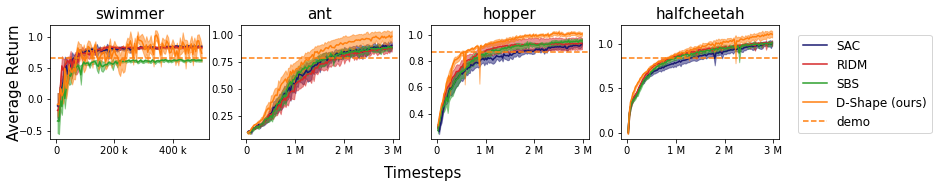

In [46]:
# comparison to other methods

for demo_level in ["medium"]:
    figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))

    for env_id in ENV_IDS:
        eval_data_dict = {
                  f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, run_ids = run_ids, demo_level=demo_level, normalize=normalize),        
                  f"RIDM": combine_eval_logs(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level),                                     
                  f"SBS": combine_eval_logs(f"{RESULTS_DIR}/sbs_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level),                                     
                  f"D-Shape (ours)": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
        }
        plot_algo_with_demo(eval_data_dict, 
                            axis=axis[fig_locs[env_id]],
                            demo_level=demo_level,
                            env_id=env_id, eval_mode=True,
                            normalize=normalize)
#     figure.suptitle(f"Goal strategy={goal_strat}, demo={demo_level}\n",
#                    fontsize=15)
    figure.text(0.70, -0.1, "Timesteps", 
                ha='center', va='center',
                fontsize=15)
    figure.text(0.07, 0.5, "Average Return", 
                ha='center', va='center', rotation='vertical',
                fontsize=15)
    
    axis[fig_locs[env_id]].legend(fontsize=12, 
                                  bbox_to_anchor=(2.0, 0.0), 
                                  loc='lower right')
    
    figure.subplots_adjust(right=1.25, left=0.125, 
                           wspace= 0.20)
    figure.show()
#     figure.savefig(f"../figures/core-baselines_goal-strat={goal_strat}_demo={demo_level}.pdf", bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/her_demo_results_final//huber+env_time_feat_rl_displace-t=1_demo=optimal/log/sac_Reacher-v2_1/evaluations.npz'

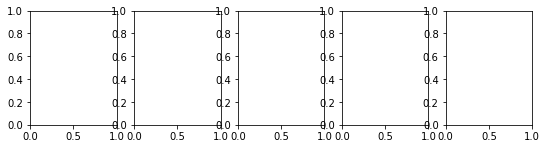

In [95]:
# varying the demo quality huber
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
for env_id in ENV_IDS:
    eval_data_dict = {
#           f"{algo}": combine_eval_logs(f"/scratch/cluster/clw4542/her_demo_earlyterm/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize, run_ids=run_ids),                
          f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize, run_ids=run_ids),        
        f"SAC+Huber, demo=best": combine_eval_logs(f"{RESULTS_DIR}/huber+env_time_feat_rl_displace-t={displace_t}_demo=optimal/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"SAC+Huber, demo=medium": combine_eval_logs(f"{RESULTS_DIR}/huber+env_time_feat_rl_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"SAC+Huber, demo=worst": combine_eval_logs(f"{RESULTS_DIR}/huber+env_time_feat_rl_displace-t={displace_t}_demo=worst/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
        f"SAC+Huber, demo=random": combine_eval_logs(f"{RESULTS_DIR}/huber+env_time_feat_rl_displace-t={displace_t}_demo=random/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
    }
    plot_algo_with_demo(eval_data_dict, 
                        axis=axis[fig_locs[env_id]],
                        demo_level="all",
                        env_id=env_id, eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
# figure.suptitle(f"Varying demo quality, goal strategy={goal_strat}",
#                fontsize=25)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=15)
figure.text(0.07, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=15)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(2.43, 0.0), 
                              loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()
# figure.savefig(f"../figures/varying-demo_huber.pdf", bbox_inches="tight")

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


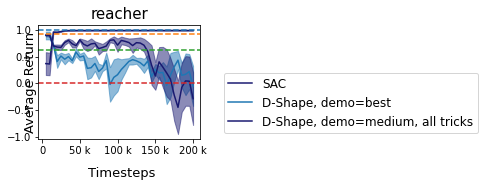

In [69]:
# varying the demo quality dshape
raw = True
obs_type = "raw"
goal_strat = "episode"
ENV_IDS = ["Reacher-v2"]
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(2,2.1))
for env_id in ENV_IDS:
    eval_data_dict = {
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
        f"D-Shape, demo=best": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=optimal_pretrain=False/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=best": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=optimal_pretrain=False/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist pos, gamma=1": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_SIGNNEG_gamma=1.0/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg, gamma=1": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_SIGNPOS_gamma=1.0/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg, gamma=0.99": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_pretrain=False/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),

        #         f"D-Shape, demo=medium, all tricks": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw=False_termphi0={termphi0}_goal-strat=random_n-goal=3_time-feat={time_feat}_displace-t={displace_t}_demo=medium_SIGNNEG/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),

        
#         f"D-Shape, demo=worst": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=worst_pretrain=False/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
#         f"D-Shape, demo=random": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=random_pretrain=False/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
    }
    plot_algo_with_demo(eval_data_dict, 
#                         axis=axis[fig_locs[env_id]],
                        axis=axis,
                        demo_level="all",
                        env_id=env_id, eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
# figure.suptitle(f"Varying demo quality, goal strategy={goal_strat}",
#                fontsize=25)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=13)
figure.text(0.07, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=13)

# axis[fig_locs[env_id]].legend(fontsize=12, 
#                               bbox_to_anchor=(2.30, 0.0), 
#                               loc='lower right')
axis.legend(fontsize=12, 
            bbox_to_anchor=(2.750, 0.0), 
            loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()
# figure.savefig(f"../figures/varying-demo_goal-strat={goal_strat}.pdf", bbox_inches="tight")

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


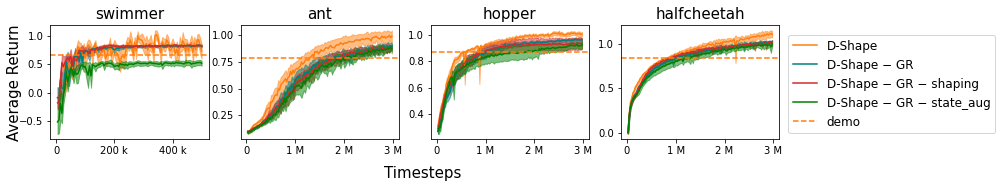

In [49]:
# ablation
for demo_level in ["medium"]:
    figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
    for env_id in ENV_IDS:
        eval_data_dict = {
            f"D-Shape": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
            f"D-Shape − GR": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),                                     
            f"D-Shape − GR − shaping": combine_eval_logs(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),                                     
            f"D-Shape − GR − state_aug": combine_eval_logs(f"{RESULTS_DIR}/potential_dense_time_feat_rl_termphi0={termphi0}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        }
        plot_algo_with_demo(eval_data_dict, 
                            axis=axis[fig_locs[env_id]],
                            demo_level=demo_level,
                            env_id=env_id, eval_mode=True,
                            normalize=normalize)

        #     figure.suptitle(f"Goal strategy={goal_strat}, demo={demo_level}\n",
#                    fontsize=15)

    figure.text(0.70, -0.1, "Timesteps", 
                ha='center', va='center',
                fontsize=15)
    figure.text(0.07, 0.5, "Average Return", 
                ha='center', va='center', rotation='vertical',
                fontsize=15)
    
    axis[fig_locs[env_id]].legend(fontsize=12, 
                                  bbox_to_anchor=(2.40, 0.0), 
                                  loc='lower right')

    figure.subplots_adjust(right=1.25, left=0.125, 
                           wspace= 0.20)
    figure.show()
#     figure.savefig(f"../figures/ablation_goal-strat={goal_strat}_demo={demo_level}.pdf", bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/her_demo_results_final//her_demo_rew=potential_dense_raw=True_termphi0=True_goal-strat=episode_n-goal=10_time-feat=True_displace-t=1_demo=medium_gamma=0.999999/log/sac_Reacher-v2_1/evaluations.npz'

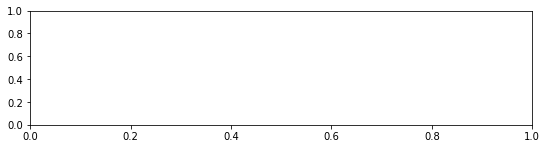

In [28]:
# goal distances
normalize = False
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
# figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(2,2.1))

for env_id in ENV_IDS:
    eval_data_dict = {
#         f"D-Shape, demo=best": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=optimal/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=medium": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist pos, gamma=0.99": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=medium, dist neg, gamma=0.99": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.99/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist pos, gamma=0.999999": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.999999/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg, gamma=0.999999": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.999999/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),

#         f"D-Shape, demo=worst": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=worst/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
#         f"D-Shape, demo=random": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=random/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
    }
    
    plot_goal_dist(eval_data_dict, 
                   axis=axis[fig_locs[env_id]],
#                    axis=axis,
                   env_id=env_id,
                  )
# figure.suptitle(f"Goal distances, goal strategy={goal_strat}, demo={demo_level}",
#                fontsize=25)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=15)
figure.text(0.07, 0.5, "Average Goal Distance", 
            ha='center', va='center', rotation='vertical',
            fontsize=15)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(-4, -1.2), 
                              loc='lower left')
# axis.legend(fontsize=12, 
#             bbox_to_anchor=(2.30, 0.0), 
#             loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()
# figure.savefig(f"../figures/goal-dist_goal-strat={goal_strat}.pdf", bbox_inches="tight")


###  Misc Figures

#### Sparse Mujoco Experiments

In [31]:
normalize = True
ENV_IDS = ["Swimmer-v2", "Hopper-v2", "Ant-v2"]  # "Hopper-v2", potential_corrected results running
raw_option = True
run_ids = [1,2,3, 4, 5]
fig_locs = {env_id: i for i, env_id in enumerate(ENV_IDS)}
demo = "medium"

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


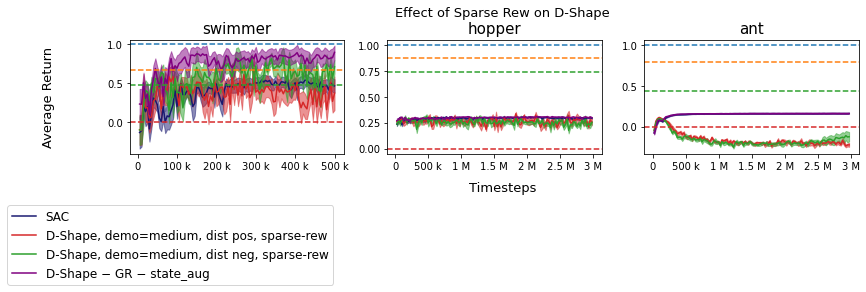

In [32]:
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
# figure, axis = plt.subplots(1,1, figsize=(2,2.1))
for env_id in ENV_IDS:
    eval_data_dict = {
        # TODO: covnert to sparse rew
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl_sparse-task-rew=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
        f"D-Shape, demo={demo}, dist pos, sparse-rew": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99_sparse-task-rew=True_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo={demo}, dist neg, sparse-rew": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99_sparse-task-rew=True_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape − GR − state_aug": combine_eval_logs(f"{RESULTS_DIR}/potential_dense_time_feat_rl_termphi0={termphi0}_displace-t={displace_t}_demo={demo}_sparse-task-rew=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
    }
    plot_algo_with_demo(eval_data_dict, 
                       axis=axis[fig_locs[env_id]],
    #                     axis=axis,
                        demo_level="all",
                        env_id=env_id, 
                        eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
#     axis[fig_locs[env_id]].set_title(f"\nEffect of Goal Repr. on {env_id}")

figure.suptitle(f"Effect of Sparse Rew on D-Shape\n",x=0.7,y=1.1, fontsize=13)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=13)
figure.text(0.0, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=13)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(-3, -1.2), 
                              loc='lower left')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)
figure.show()

#### Cos/Sine Repr

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


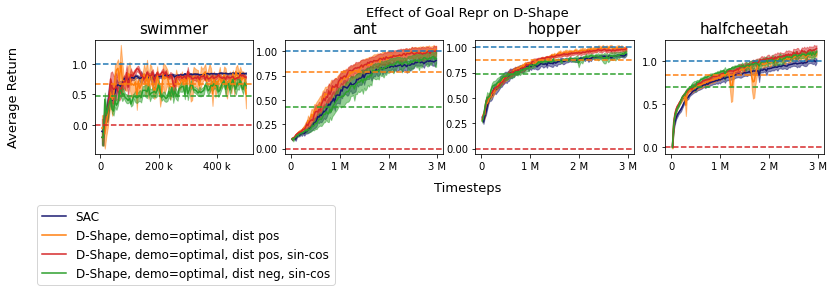

In [72]:
# effect of cos/sine representation versus radians for goal states
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
# figure, axis = plt.subplots(1,1, figsize=(2,2.1))
for env_id in ENV_IDS:
    eval_data_dict = {
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
        f"D-Shape, demo={demo}, dist pos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo={demo}, dist neg": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo={demo}, dist neg": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo={demo}, dist pos, sin-cos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo={demo}, dist neg, sin-cos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo}_gamma=0.99_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
    }
    plot_algo_with_demo(eval_data_dict, 
                       axis=axis[fig_locs[env_id]],
    #                     axis=axis,
                        demo_level="all",
                        env_id=env_id, 
                        eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
#     axis[fig_locs[env_id]].set_title(f"\nEffect of Goal Repr. on {env_id}")

figure.suptitle(f"Effect of Goal Repr on D-Shape\n",x=0.7,y=1.1, fontsize=13)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=13)
figure.text(0.0, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=13)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(-4, -1.2), 
                              loc='lower left')

# axis.legend(fontsize=12, 
#                bbox_to_anchor=(3, 0.0), 
#                loc='lower right')
figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)
figure.show()

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


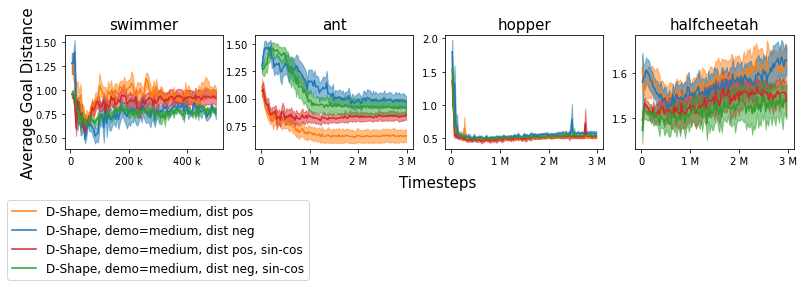

In [64]:
# goal distances
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
# figure, axis = plt.subplots(1,1, figsize=(2,2.1))

for env_id in ENV_IDS:    
    eval_data_dict = {
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
        f"D-Shape, demo=medium, dist pos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.99/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist pos, sin-cos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.99_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg, sin-cos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.99_sin-cos-repr=True/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
    }
    plot_goal_dist(eval_data_dict, 
                   axis=axis[fig_locs[env_id]],
#                    axis=axis,
                   env_id=env_id,
                  )
# figure.suptitle(f"Goal distances, goal strategy={goal_strat}, demo={demo_level}",
#                fontsize=25)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=15)
figure.text(0.07, 0.5, "Average Goal Distance", 
            ha='center', va='center', rotation='vertical',
            fontsize=15)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(-4, -1.2), 
                              loc='lower left')
# axis.legend(fontsize=12, 
#             bbox_to_anchor=(3, 0.0), 
#             loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()

#### Interaction between Gamma and Sign of Goal Distance (reviewer response)

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


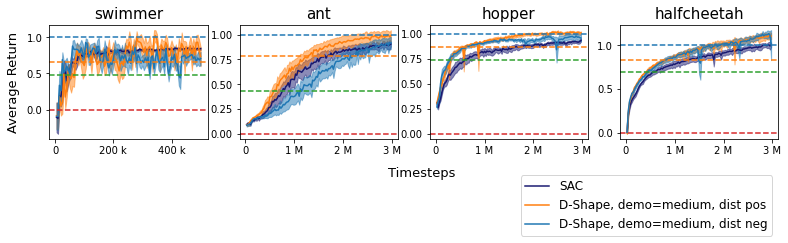

In [118]:
run_ids = [1,2,3, 4,5]
figure, axis = plt.subplots(1,len(ENV_IDS), figsize=(9,2.1))
for env_id in ENV_IDS:
    eval_data_dict = {
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
        # original
#         f"D-Shape, demo=medium": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
        # test buffer size
#         f"D-Shape, demo=medium, buffer=small": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_buffer=1000000.0/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),

        f"D-Shape, demo=medium, dist pos": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
        f"D-Shape, demo=medium, dist neg": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.99/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),

#         f"D-Shape, demo=medium, dist pos, gamma=0.999999": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.999999/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=medium, dist neg, gamma=0.999999": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=0.999999/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=medium, dist neg, gamma=1": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_corrected_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=1.0/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),
#         f"D-Shape, demo=medium, dist pos, gamma=1": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_gamma=1.0/log/{algo}_{env_id}", env_id=env_id, run_ids=run_ids, demo_level=demo_level, normalize=normalize),

    }
    plot_algo_with_demo(eval_data_dict, 
                        axis=axis[fig_locs[env_id]],
                        demo_level="all",
                        env_id=env_id, eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=13)
figure.text(0.07, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=13)
axis[fig_locs[env_id]].legend(fontsize=12, 
                              bbox_to_anchor=(1.0, -0.9), 
                              loc='lower right')
figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)
figure.show()

#### Raw vs Full State on Swimmer

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


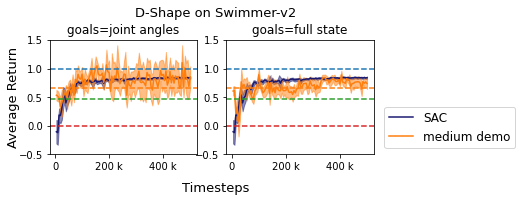

In [19]:
# effect of raw versus full state on Swimmer
env_id = "Swimmer-v2"
title_lists = ["goals=joint angles", "goals=full state"]
figure, axis = plt.subplots(1,2, figsize=(4,2.1))
for i, raw_option in enumerate([True, False]):
    eval_data_dict = {
        f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),        
#         f"best demo": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=optimal/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
        f"medium demo": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=medium_SIGNNEG/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),
#         f"worst demo": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=worst/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
#         f"random demo": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw_option}_termphi0={termphi0}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo=random/log/{algo}_{env_id}", env_id=env_id, demo_level=demo_level, normalize=normalize),   
    }
    plot_algo_with_demo(eval_data_dict, 
                        axis=axis[i],
#                         axis=axis,
                        demo_level="all",
                        env_id=env_id, 
                        eval_mode=True,
                        normalize=normalize,
                        show_demo_labels=False)
    axis[i].set_title(f"\n{title_lists[i]}")
    axis[i].set_ylim(-0.5, 1.5)
figure.suptitle("D-Shape on Swimmer-v2\n",x=0.7,y=1.1, fontsize=13)
figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=13)
figure.text(0.0, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=13)

axis[1].legend(fontsize=12, 
               bbox_to_anchor=(2, 0.0), 
               loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()
# figure.savefig(f"../figures/swimmer_raw-vs-full.pdf", bbox_inches="tight")

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


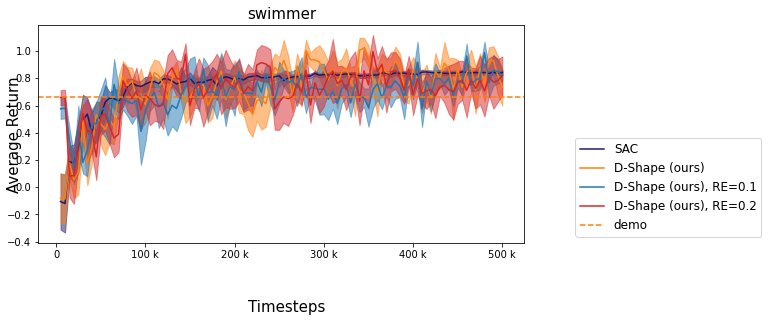

In [108]:
# effect of random exploration on swimmer
normalize=True
env_id = "Swimmer-v2"
run_ids = [1,2,3,4,5]

figure, axis = plt.subplots(1,1)
eval_data_dict = {
          f"SAC": combine_eval_logs(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}", env_id=env_id, run_ids = run_ids, demo_level="medium", normalize=normalize),        
          f"D-Shape (ours)": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
          f"D-Shape (ours), RE=0.1": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}_pretrain=False_re=0.1/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
          f"D-Shape (ours), RE=0.2": combine_eval_logs(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_termphi0={termphi0}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}_pretrain=False_re=0.2/log/{algo}_{env_id}",run_ids = run_ids, env_id=env_id, demo_level=demo_level, normalize=normalize),   
}
plot_algo_with_demo(eval_data_dict, 
                    axis=axis,
                    demo_level="medium",
                    env_id=env_id, eval_mode=True,
                    normalize=normalize)

figure.text(0.70, -0.1, "Timesteps", 
            ha='center', va='center',
            fontsize=15
           )
figure.text(0.07, 0.5, "Average Return", 
            ha='center', va='center', rotation='vertical',
            fontsize=15
           )

axis.legend(fontsize=12, 
            bbox_to_anchor=(1.50, 0.0), 
            loc='lower right')

figure.subplots_adjust(right=1.25, left=0.125, 
                       wspace= 0.20)

figure.show()

#### Early Termination

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


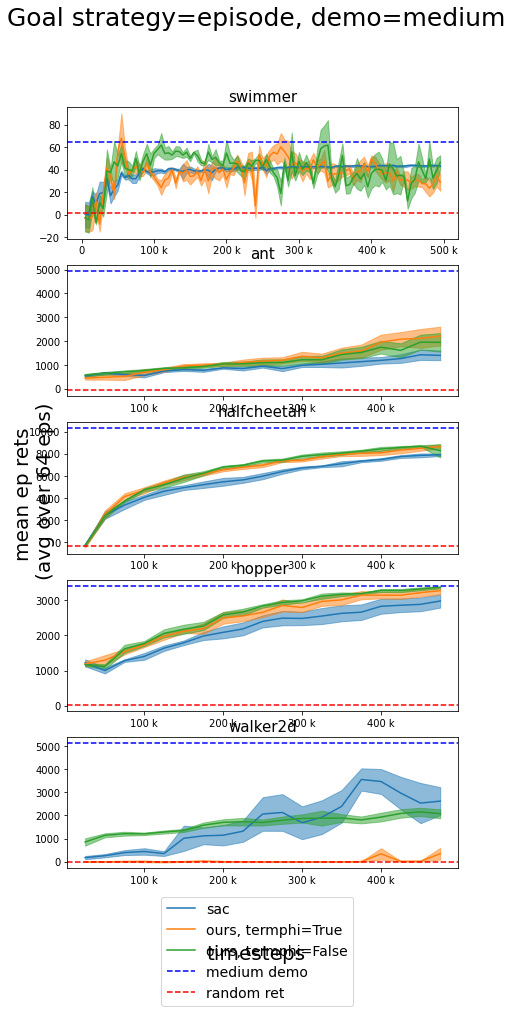

In [189]:
goal_strat = "episode"
results_dir_pbrs = "/scratch/cluster/clw4542/her_demo_pbrs"
results_dir_earlyterm = "/scratch/cluster/clw4542/her_demo_earlyterm"
results_dir_orig = "/scratch/cluster/clw4542/her_demo_results_final"
run_ids=[1,2,3]
max_ts=0.5e+6
demo_levels = ["medium"]
fig_locs = {
            "Swimmer-v2": 0,
            "Ant-v2": 1,
            "HalfCheetah-v2": 2,
            "Hopper-v2": 3,
            "Walker2d-v2": 4
           }
for demo_level in demo_levels:
    figure, axis = plt.subplots(5, figsize=(7,14))
    for env_id in ["Swimmer-v2", "Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]:
        if env_id in ["Walker2d-v2"]:
            results_dir = results_dir_earlyterm
        else:
            results_dir = results_dir_pbrs
            
        # baselines
        eval_data_dict = {
                  f"{algo}": combine_eval_logs(f"{results_dir_orig}/time_feature_rl/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),        
#                       f"{algo}, potential rew, termphi0=True": combine_eval_logs(f"{results_dir}/potential_dense_time_feat_rl_termphi0=True_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),                                     
#                       f"{algo}, potential rew, termphi0=False": combine_eval_logs(f"{results_dir_orig}/potential_dense_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),                                     
#                   f"{algo}, noterm": combine_eval_logs(f"{results_dir}/time_feature_rl/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),        
#                   f"{algo}, noterm, potential rew, termphi0=False": combine_eval_logs(f"{results_dir}/potential_dense_time_feat_rl_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),                                     
                  f"ours, termphi=True": combine_eval_logs(f"{results_dir_pbrs}/her_demo_rew=potential_dense_raw={raw}_termphi0=True_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),   
                  f"ours, termphi=False": combine_eval_logs(f"{results_dir_orig}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t={displace_t}_demo={demo_level}/log/{algo}_{env_id}", run_ids=run_ids, max_ts=max_ts),   
        }
        plot_algo_with_demo(eval_data_dict, 
                            axis=axis[fig_locs[env_id]],
                            demo_level=demo_level,
                            env_id=env_id, eval_mode=True)
    figure.suptitle(f"Goal strategy={goal_strat}, demo={demo_level}",
                   fontsize=25)
    figure.text(0.5, 0.04, "timesteps", 
                ha='center', va='center',
                fontsize=20)
    figure.text(0.06, 0.5, "mean ep rets \n(avg over 64 eps)", 
                ha='center', va='center', rotation='vertical',
                fontsize=20)
    axis[fig_locs[env_id]].legend(fontsize=14, 
                                  bbox_to_anchor=(0.75, -1.1), 
                                  loc='lower right')

    figure.show()
#     figure.savefig(f"../figures/core_goal-strat={goal_strat}_demo={demo_level}.pdf")

#### Robustness to Inference Time Demonstration

In [21]:
# robustness to inference time demonstration
from utils.viz_helpers import df_to_latex

# demo_robust_results = {
#  'Swimmer-v2': {'optimal': {'mean': 21.47434291454215, 'std': 10.038884092097538}, 
#                 'medium': {'mean': 59.18384434217201, 'std': 1.4820325239557541}, 
#                 'worst': {'mean': -20.514649535965233, 'std': 1.8233885109111536}, 
#                 'random': {'mean': -21.763715364001932, 'std': 1.2117288229201806}}, 
#  'HalfCheetah-v2': {'optimal': {'mean': 14799.189258017013, 'std': 802.737485527143}, 
#                     'medium': {'mean': 14910.46239214529, 'std': 69.19853940816074}, 
#                     'worst': {'mean': 14920.550038782028, 'std': 76.48452459805026}, 
#                     'random': {'mean': 14955.032438925187, 'std': 84.93405050469242}}, 
#  'Ant-v2': {'optimal': {'mean': 6536.2478786258125, 'std': 123.69044965396722}, 
#             'medium': {'mean': 6387.973159882378, 'std': 783.5307656050454}, 
#             'worst': {'mean': 6542.945377907429, 'std': 97.4169744778695}, 
#             'random': {'mean': 6345.367683417502, 'std': 993.5540555930233}}, 
#  'Hopper-v2': {'optimal': {'mean': 3768.7434334542722, 'std': 57.60284456071072}, 
#                'medium': {'mean': 3860.2170870441387, 'std': 18.79147849017104}, 
#                'worst': {'mean': 3851.51503470881, 'std': 27.75916835449354}, 
#                'random': {'mean': 3234.6193713614284, 'std': 95.57898290228141}}
# }

demo_robust_results = {
    'Swimmer-v2': {'optimal': {'mean': 0.3515778487625756, 'std': 0.21671224777948825}, 
                   'medium': {'mean': 1.1583957204237296, 'std': 0.0363095033469388}, 
                   'worst': {'mean': -0.44044114866962414, 'std': 0.03640371832419868}, 
                   'random': {'mean': -0.4635080195836307, 'std': 0.025306495143154417}}, 
    'HalfCheetah-v2': {'optimal': {'mean': 1.189397653265174, 'std': 0.1071697209644101}, 
                       'medium': {'mean': 1.2027165814517091, 'std': 0.005913700430841669}, 
                       'worst': {'mean': 1.1892928676355543, 'std': 0.10283124488867605}, 
                       'random': {'mean': 1.2045509131805419, 'std': 0.008878562534236861}}, 
    'Ant-v2': {'optimal': {'mean': 1.0369166537055048, 'std': 0.01524938874110403}, 
               'medium': {'mean': 1.036818495545825, 'std': 0.015431037750400181}, 
               'worst': {'mean': 1.0297573928171042, 'std': 0.020952905323174648}, 
               'random': {'mean': 1.004670682230637, 'std': 0.1286684026101653}}, 
    'Hopper-v2': {'optimal': {'mean': 0.9559472846152315, 'std': 0.019848539192619752}, 
                  'medium': {'mean': 0.986424521772118, 'std': 0.005562992014654514}, 
                  'worst': {'mean': 0.9824619347555259, 'std': 0.007877289922264465}, 
                  'random': {'mean': 0.8305702812901727, 'std': 0.02653821221340357}}
}

formatted_dict = {}
for env_id, demo_dict in demo_robust_results.items():
    formatted_dict[env_id] = {}
    for demo_level, mean_std_dict in demo_dict.items():
        mean, std = mean_std_dict["mean"], mean_std_dict["std"]
        formatted_dict[env_id][demo_level] = f"{mean:.3f} ({std:.3f})"
    
formatted_df = pd.DataFrame.from_dict(formatted_dict, orient="index")
df_to_latex(pd.DataFrame.from_dict(formatted_dict, orient="index"))